In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from collections import Counter
from scipy.stats import wilcoxon, mannwhitneyu
from statsmodels.stats.multitest import multipletests
from lifelines import CoxTimeVaryingFitter
from scipy.stats import linregress, pearsonr, spearmanr
from scipy.cluster.hierarchy import leaves_list
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform, pdist
import warnings
warnings.filterwarnings('ignore')

# Load metadata, relative abundance, and drug exposure

In [2]:
df_sample = pd.read_excel("ST4_oralASV_alloHCT.xlsx", sheet_name='Table S4b')
df_sample['Patient ID'] = df_sample['Patient ID'].astype(str)
df_sample['Sample ID'] = df_sample['Sample ID'].astype(str)
df_sample.columns = ['SampleID','PatientID','DayRelativeToNearestHCT','TotalLoad','OralFraction','OralLoad','GutFraction','GutLoad','Timepoint','StoolConsistency','FungalCulturability']
df_sample = df_sample.set_index('SampleID')
df_sample['log10_TotalLoad'] = np.log10(df_sample.TotalLoad)
df_sample['log10_OralFraction'] = np.log10(df_sample.OralFraction)

df_ent = pd.read_excel("Enterococcus_abundance.xlsx")
df_ent.SampleID = df_ent.SampleID.astype(str)
df_ent = df_ent.set_index('SampleID')
df_ent.columns = ['EnterococcusFraction','EnterococcusLoad']

df_sample = pd.merge(df_sample, df_ent, left_index=True, right_index=True, how='left')
df_sample['Enterococcus2OralRatio'] = df_sample['EnterococcusFraction']/df_sample['OralFraction']
df_sample['log10_EnterococcusLoad'] = np.log10(df_sample['EnterococcusLoad'])
df_sample['log10_Enterococcus2OralRatio'] = np.log10(df_sample['Enterococcus2OralRatio'])

df_sample.head()

,PatientID,DayRelativeToNearestHCT,TotalLoad,OralFraction,OralLoad,GutFraction,GutLoad,Timepoint,StoolConsistency,FungalCulturability,log10_TotalLoad,log10_OralFraction,EnterococcusFraction,EnterococcusLoad,Enterococcus2OralRatio,log10_EnterococcusLoad,log10_Enterococcus2OralRatio
SampleID,,,,,,,,,,,,,,,,,
1000A,1000,-9,NaN,0.065440,NaN,0.934560,NaN,0,formed,NaN,NaN,-1.184159,0.000000,0.0,0.000000,-inf,-inf
1000B,1000,-4,NaN,0.270878,NaN,0.729122,NaN,5,liquid,NaN,NaN,-0.567227,0.000000,0.0,0.000000,-inf,-inf
1000C,1000,6,NaN,0.000752,NaN,0.999248,NaN,15,liquid,NaN,NaN,-3.123525,0.001053,NaN,1.400001,NaN,0.146128
1000D,1000,9,NaN,0.149727,NaN,0.850273,NaN,18,semi-formed,NaN,NaN,-0.824701,0.001651,NaN,0.011027,NaN,-1.957548
1000E,1000,13,NaN,0.010265,NaN,0.989735,NaN,22,formed,NaN,NaN,-1.988626,0.004261,NaN,0.415094,NaN,-0.381853


In [3]:
# correlation between Enterococcus relative abundance and oral bacterial fraction
pearsonr(df_sample.OralFraction, df_sample.EnterococcusFraction)

PearsonRResult(statistic=-0.21704075518521565, pvalue=1.823140570321084e-111)

In [4]:
len(df_sample), len(set(df_sample.PatientID)), len(df_sample[df_sample.TotalLoad.notnull()]), len(df_sample[df_sample.TotalLoad.isnull()])

(10433, 1276, 3108, 7325)

In [5]:
Counter((df_sample.loc[df_sample.TotalLoad.notnull(), 'TotalLoad']<1e7))

Counter({False: 1995, True: 1113})

In [6]:
df_count = pd.read_csv("count_wide_format.csv.gz", compression="gzip", index_col=0)
df_count.head()

,ASV_1,ASV_10,ASV_100,ASV_1000,ASV_10000,ASV_10007,ASV_10010,ASV_10011,ASV_10012,ASV_10013,...,ASV_9956,ASV_9959,ASV_997,ASV_999,ASV_9991,ASV_9992,ASV_9994,ASV_9996,ASV_9997,ASV_9998
SampleID,,,,,,,,,,,,,,,,,,,,,
574B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1233L,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1428JJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1532B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1814Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_relabun = pd.read_csv("relative_abundance_wide_format.csv.gz", compression="gzip", index_col=0)
df_relabun.head()

,ASV_1,ASV_10,ASV_100,ASV_1000,ASV_10000,ASV_10007,ASV_10010,ASV_10011,ASV_10012,ASV_10013,...,ASV_9956,ASV_9959,ASV_997,ASV_999,ASV_9991,ASV_9992,ASV_9994,ASV_9996,ASV_9997,ASV_9998
SampleID,,,,,,,,,,,,,,,,,,,,,
574B,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1233L,0.0,0.000386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1428JJ,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1532B,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1814Z,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df_drug = pd.read_csv("antibiotic_exposure_long_format.csv.gz", compression="gzip")
df_drug.PatientID = df_drug.PatientID.astype(str)
class2include = list(set(df_drug.Antibiotic))
df_drug.head()

,PatientID,Antibiotic,DayRelativeToNearestHCT,Timepoint
0,1000,quinolones,-169,-160
1,1000,aztreonam,-160,-151
2,1000,vancomycin_iv,-160,-151
3,1000,aztreonam,-159,-150
4,1000,vancomycin_iv,-159,-150


In [9]:
df_hctmeta = pd.read_csv("metadata.csv")
df_hctmeta.PatientID = df_hctmeta.PatientID.astype(str)
df_hctmeta.head()

,PatientID,TimepointOfTransplant,HCTSource,Disease,EngraftmentDayRelativeToNearestHCT
0,FMT.0161,30,TCD,Multiple Myeloma,10.0
1,667,8,PBSC_unmodified,Leukemia,12.0
2,1277,5,PBSC_unmodified,Leukemia,11.0
3,464,8,BM_unmodified,Leukemia,19.0
4,420,6,cord,Non-Hodgkin's Lymphoma,13.0


In [10]:
df_oral_asv = pd.read_excel("ST4_oralASV_alloHCT.xlsx", sheet_name="Table S4a")
df_oral_asv.head()

,ASV,Sequence,Kingdom,Phylum,Class,Order,Family,Genus
0,ASV_10020,AGCGCAGGCGGGCATGTAAGTCTTTCTTAAAAGTTCGGGGCTCAAC...,Bacteria,Firmicutes,Negativicutes,Veillonellales-Selenomonadales,Selenomonadaceae,Centipeda
1,ASV_10022,CATCTAGGCGGCCAGATAAGTCCGAGGTGAAAACTGCCGGCTCAAC...,Bacteria,Fusobacteriota,Fusobacteriia,Fusobacteriales,Leptotrichiaceae,Leptotrichia
2,ASV_10082,TGCGTAGGTGGCGTATTAAGTCAGTGGTGAAAAGCTGCAGCTCAAC...,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Porphyromonadaceae,Porphyromonas
3,ASV_10084,AGCGTAGGCGGATTATTAAGTCAGTGGTGAAAGACGGTGGCTCAAC...,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Prevotellaceae,Alloprevotella
4,ASV_10143,CATCTAGGCGGCCAGACAAGTCTGGGGTGAAAACTTGCGGCTCAAC...,Bacteria,Fusobacteriota,Fusobacteriia,Fusobacteriales,Leptotrichiaceae,Leptotrichia


In [11]:
len(df_oral_asv.ASV)

127

In [12]:
#df_pdist_asv = pd.read_csv("../../codes/Fig3|FigS1_S3|EDFig6_9|TableS5/MSKCC_braycurtis_distance.csv.gz", compression='gzip', index_col=0)
#df_pdist_asv = df_pdist_asv.loc[df_relabun.index, df_relabun.index]
df_pdist_asv = pd.DataFrame(squareform(pdist(df_relabun, metric='braycurtis')), index=list(df_relabun.index), columns=list(df_relabun.index))
df_pdist_asv.head()

SampleID,574B,1233L,1428JJ,1532B,1814Z,420H,1872L,864D,2149D,FMT.0092II,...,FMT.0151M,890A,FMT.0021B,450A,FMT.0158R,FMT.0092X,446P,680R,FMT.0053C,948D
SampleID,,,,,,,,,,,,,,,,,,,,,
574B,0.000000,0.995386,0.218683,0.999554,0.999376,0.659136,0.998952,0.997412,0.995965,0.999075,...,0.017093,0.999654,0.998857,0.996644,0.993506,0.496293,0.999654,0.598254,0.998869,0.995633
1233L,0.995386,0.000000,0.988302,0.995948,0.983758,0.978654,0.998548,0.996653,0.937293,0.996879,...,0.992308,0.997726,0.996750,0.994006,0.992901,0.993915,0.998661,0.994116,0.993984,0.873517
1428JJ,0.218683,0.988302,0.000000,0.860140,0.997382,0.651688,0.998631,0.834971,0.994124,0.919947,...,0.212312,0.971717,0.978566,0.969025,0.889392,0.494347,0.931676,0.553795,0.840754,0.994123
1532B,0.999554,0.995948,0.860140,0.000000,0.998005,0.990209,0.972875,0.838305,0.898934,0.850544,...,0.996644,0.824897,0.919598,0.907883,0.842267,0.970201,0.861938,0.934480,0.610826,0.999900
1814Z,0.999376,0.983758,0.997382,0.998005,0.000000,0.990426,0.999446,0.998848,0.993505,0.998729,...,0.998848,0.981397,0.847216,0.994882,0.993161,0.994419,0.997900,0.997748,0.998729,0.990386


In [13]:
df_tax = pd.read_csv("taxonomy.csv")
df_tax.head()

,ASV,Sequence,Kingdom,Phylum,Class,Order,Family,Genus,LowestClassifiedTaxa,ClosestHMPTaxa,ConfidenceKingdom,ConfidencePhylum,ConfidenceClass,ConfidenceOrder,ConfidenceFamily,ConfidenceGenus,TaxonomyColor,TaxonomyColorOrder
0,ASV_1,AGCGCAGGCGGTTGCTTAGGTCTGATGTGAAAGCCTTCGGCTTAAC...,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus,Lactobacillus,Lactobacillus,100,100,100,100,100,100,#1635A4,163
1,ASV_10,AGCGTAGACGGAAGAGCAAGTCTGATGTGAAAGGCTGGGGCTTAAC...,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Blautia,Blautia,Blautia,100,100,100,100,100,93,#AD998C,7
2,ASV_100,AGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAAC...,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides,Bacteroides,100,100,100,100,100,100,#16DDD3,44
3,ASV_1000,TGCGTAGGTGGTTTCTTAAGTCAGAGGTGAAAGGCTACGGCTCAAC...,Bacteria,Firmicutes,Clostridia,Peptostreptococcales-Tissierellales,Peptostreptococcaceae,Romboutsia,Romboutsia,Clostridia,100,100,100,100,100,100,#BEA89A,21
4,ASV_10000,AGCGTAGACGGTGTGGCAAGTCTGATGTGAAAGGCATGGGCTCAAC...,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Blautia,Blautia,Blautia,100,100,100,100,100,100,#BEA89A,21


# Fig. 3a

In [14]:
unique_color = df_tax[['TaxonomyColor','TaxonomyColorOrder']].drop_duplicates().sort_values(by='TaxonomyColorOrder').reset_index(drop=True)
relab_asv_grouped = np.zeros((len(df_relabun.index),len(unique_color.index)))
for k,o in enumerate(unique_color.TaxonomyColorOrder):
    relab_asv_grouped[:,k] = df_relabun[set(df_relabun.columns).intersection(set(df_tax[df_tax.TaxonomyColorOrder==o].ASV))].sum(axis=1).values
df_relabun_grouped = pd.DataFrame(relab_asv_grouped, index=df_relabun.index, columns=unique_color.TaxonomyColor)
df_relabun_grouped = df_relabun_grouped.loc[df_sample.index]
df_relabun_grouped.head()

TaxonomyColor,#D6BDAD,#685C54,#9F8D81,#BBA597,#84746A,#C8B1A2,#AD998C,#918075,#76685F,#CFB7A7,...,#E62727,#DC2020,#D21818,#C81212,#BE0B0B,#B40404,#FD3636,#F83333,#F32F2F,#EE2C2C
SampleID,,,,,,,,,,,,,,,,,,,,,
1000A,0.070757,0.01726,0.040982,0.0,0.009816,0.019877,0.000000,0.054315,0.215051,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000B,0.000000,0.00911,0.000000,0.0,0.001518,0.000000,0.014273,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000C,0.000000,0.00000,0.000000,0.0,0.000451,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000D,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000413,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000E,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000581,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
%%capture

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,5))

# we do not need to plot all samples during code development
# set n_samples_to_plot a small number
n_samples_to_plot = 200#int(1e10)
total_sample_number = len(df_relabun_grouped)

# find clusters based on compostional distance 
Y = sch.linkage(squareform(df_pdist_asv.loc[df_sample.index,df_sample.index].values), method='average')

# plot stacked bars of microbiota composition
df_relabun_grouped_reordered = df_relabun_grouped.loc[df_sample.index].iloc[leaves_list(Y)]
_ = df_relabun_grouped_reordered.iloc[0:np.min([n_samples_to_plot, total_sample_number])].plot.bar(
    stacked=True, 
    color=df_relabun_grouped_reordered.columns, 
    legend=None, 
    width=1.0, 
    ax=ax[0], 
    ylim=[0,1]
)
_ = ax[0].set_ylabel('')
_ = ax[0].set_yticks([])
_ = ax[0].set_yticks([], minor=True)
_ = ax[0].set_xlabel('')
_ = ax[0].set_xticks([])
_ = ax[0].set_xticks([], minor=True)
        
# plot stacked bars of oral bacterial fraction
_ = df_sample.iloc[leaves_list(Y)].iloc[0:np.min([n_samples_to_plot, total_sample_number])].OralFraction.plot.bar(
    color=(0.4980392156862745, 0.4980392156862745, 0.4980392156862745), 
    legend=None, 
    width=1.0, 
    ax=ax[1], 
    ylim=[0,1]
)
_ = ax[1].set_ylabel('')
_ = ax[1].set_yticks([])
_ = ax[1].set_yticks([], minor=True)
_ = ax[1].set_xlabel('')
_ = ax[1].set_xticks([])
_ = ax[1].set_xticks([], minor=True)

# plot binarized qPCR values
df_qpcr_reordered = deepcopy(df_sample.iloc[leaves_list(Y)])
df_qpcr_reordered['Value'] = 1
df_qpcr_reordered['BarColor'] = 'lightgrey'
df_qpcr_reordered.loc[(df_qpcr_reordered.TotalLoad.notnull())&(df_qpcr_reordered.TotalLoad>=1e7),'BarColor'] = 'orangered'
df_qpcr_reordered.loc[(df_qpcr_reordered.TotalLoad.notnull())&(df_qpcr_reordered.TotalLoad<1e7),'BarColor'] = 'dodgerblue'
_ = df_qpcr_reordered.iloc[0:np.min([n_samples_to_plot, total_sample_number])].Value.plot.bar(
    stacked=False,
    color=df_qpcr_reordered.BarColor,
    legend=None, 
    width=1.0, 
    ax=ax[2],
    ylim=[0,1]
)
_ = ax[2].set_ylabel('')
_ = ax[2].set_yticks([])
_ = ax[2].set_yticks([], minor=True)
_ = ax[2].set_xlabel('')
_ = ax[2].set_xticks([])
_ = ax[2].set_xticks([], minor=True)

plt.tight_layout()
plt.savefig('Fig3a.png', dpi=600, bbox_inches='tight')
plt.close()

# Fig. 3b

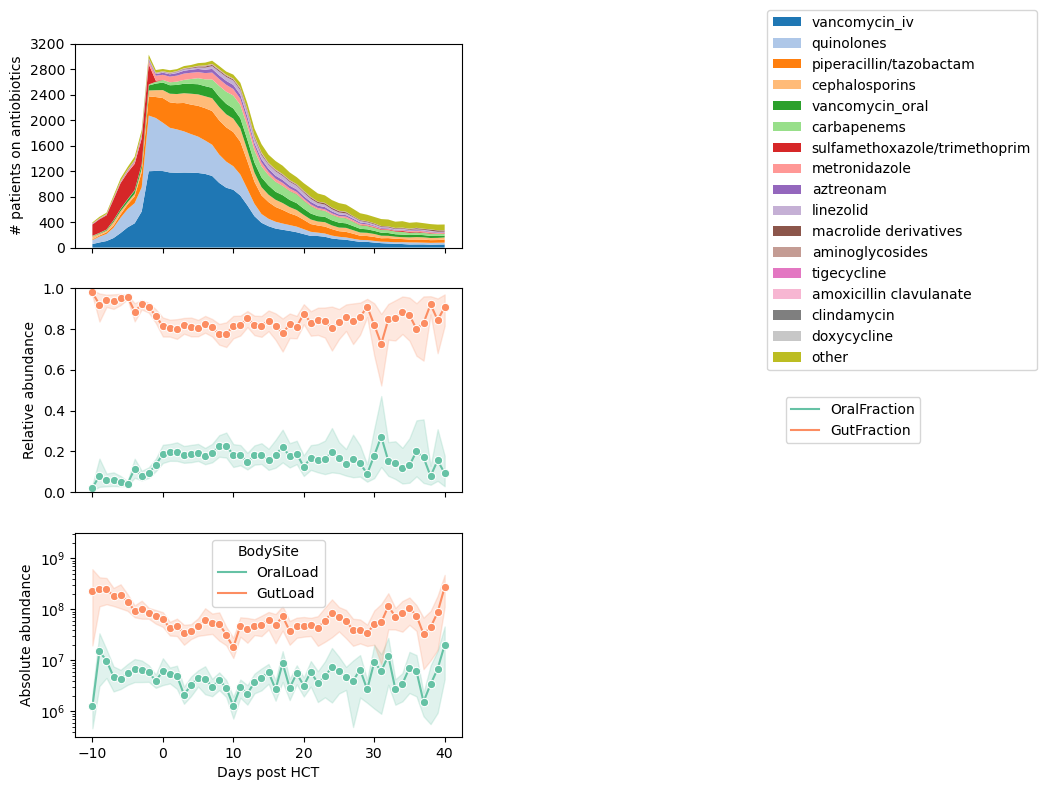

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5,9), sharex=True)

#--------------------------
# # patients on antibiotics
#--------------------------

# calculate the number of patients on each day receiving antibiotics
df_drug_usage = deepcopy(df_drug)
df_drug_usage['PatientID'] = 1
df_drug_usage = df_drug_usage[(df_drug_usage.DayRelativeToNearestHCT>=-10) & (df_drug_usage.DayRelativeToNearestHCT<=40)]
df_drug_usage = df_drug_usage.groupby(['Antibiotic','DayRelativeToNearestHCT']).agg(sum).reset_index()
df_drug_usage = pd.pivot_table(df_drug_usage, values='PatientID', index='DayRelativeToNearestHCT', columns='Antibiotic').fillna(0)

# sort drug categories based on the mean number of patients receiving the drugs
df_drug_usage_T = df_drug_usage.T
df_drug_usage_T['mean'] = df_drug_usage_T.mean(axis=1)
df_drug_usage_T = df_drug_usage_T.sort_values(by=['mean'],axis=0,ascending=False)
df_drug_usage_T = df_drug_usage_T.drop('mean', axis=1)
df_drug_usage = df_drug_usage_T.T

# move other to the last column
df_drug_usage = df_drug_usage.drop(columns=['other']).assign(other=df_drug_usage['other'])

# plot fraction of patients receiving drug administration
x = list(df_drug_usage.index)
y = df_drug_usage.T.values
_ = ax[0].stackplot(x,y, labels=df_drug_usage.columns, colors=sns.color_palette("tab20"))
_ = ax[0].legend(loc='upper right', bbox_to_anchor=(2.5, 1.2))
_ = ax[0].set_ylim([0,3200])
_ = ax[0].set_yticks([0,400,800,1200,1600,2000,2400,2800,3200])
_ = ax[0].set_ylabel('# patients on antiobiotics')


#----------------------------------------------------------
# Relative and absolute abundances of oral and gut bacteria
#----------------------------------------------------------

df2plot = deepcopy(df_sample)
df2plot = df2plot[(df2plot.DayRelativeToNearestHCT >= -10) & (df2plot.DayRelativeToNearestHCT <= 40)]
df2plot = df2plot[df2plot.TotalLoad>0]

df2plot_stacked = df2plot.set_index('DayRelativeToNearestHCT')[['OralFraction','GutFraction']].stack().reset_index()
df2plot_stacked.columns = ['DayRelativeToNearestHCT', 'BodySite', 'Fraction']
_ = sns.lineplot(x="DayRelativeToNearestHCT", y="Fraction", hue='BodySite', data=df2plot_stacked, ax=ax[1], palette='Set2', marker='o')
_ = ax[1].legend().remove()
_ = ax[1].legend(loc='upper right', bbox_to_anchor=(2.2, 0.5))

df2plot_stacked = df2plot.set_index('DayRelativeToNearestHCT')[['OralLoad','GutLoad']].stack().reset_index()
df2plot_stacked.columns = ['DayRelativeToNearestHCT', 'BodySite', 'Load']
_ = sns.lineplot(x="DayRelativeToNearestHCT", y="Load", hue='BodySite', data=df2plot_stacked, ax=ax[2], palette='Set2', marker='o')
_ = ax[2].set_yscale('log')
_ = ax[1].set_xlabel('Days post HCT')
_ = ax[2].set_xlabel('Days post HCT')
_ = ax[1].set_ylim([0,1])
_ = ax[2].set_ylim([10**5.5,10**9.5])
_ = ax[1].set_ylabel('Relative abundance')
_ = ax[2].set_ylabel('Absolute abundance')

plt.tight_layout()

# Test the pure Marker and Expansion hypotheses

In [17]:
df2 = deepcopy(df_sample)
df2 = df2[df2.TotalLoad > 0]

res = []
for pid in set(df2.PatientID):
    df2_pid = df2[df2.PatientID==pid].sort_values('Timepoint')
    transplant_tps = list(df_hctmeta[df_hctmeta.PatientID==pid].TimepointOfTransplant)
    for ttps in transplant_tps:
        # engraftment timepoint
        engraftment_day = list(df_hctmeta[(df_hctmeta.PatientID==pid)&(df_hctmeta.TimepointOfTransplant==ttps)].EngraftmentDayRelativeToNearestHCT)[0]
        if str(engraftment_day) != 'nan':
            # determine the first day of antibiotic prophylaxis
            df2_drug = df_drug[(df_drug.PatientID == pid) & (df_drug.Timepoint >= ttps-20) & (df_drug.Timepoint <= ttps+40)]
            if len(df2_drug)>0:
                prophylaxis_day = list(df2_drug[df2_drug.Timepoint==df2_drug.Timepoint.min()].DayRelativeToNearestHCT)[0]
                df2_pid_pre = df2_pid[(df2_pid.Timepoint < ttps+prophylaxis_day) & (df2_pid.Timepoint >= ttps-20)]
                df2_pid_post  = df2_pid[(df2_pid.Timepoint >= ttps+prophylaxis_day) & (df2_pid.Timepoint <= ttps+engraftment_day)]
                if len(df2_pid_pre) > 0 and len(df2_pid_post) > 0:
                    gutload_pre = np.nanmean(df2_pid_pre.GutLoad)
                    gutload_post = np.nanmean(df2_pid_post.GutLoad)
                    oralload_pre = np.nanmean(df2_pid_pre.OralLoad)
                    oralload_post= np.nanmean(df2_pid_post.OralLoad)
                    oralfrac_pre = np.nanmean(df2_pid_pre.OralFraction)
                    oralfrac_post= np.nanmean(df2_pid_post.OralFraction)
                    res.append([pid, ttps, oralfrac_pre, oralfrac_post, oralload_pre, oralload_post, gutload_pre, gutload_post])
df_res = pd.DataFrame(res, columns=['PatientID','TransplantTimepoint','OralFracPre','OralFracPost','OralLoadPre','OralLoadPost','GutLoadPre','GutLoadPost'])
df_res.head()

,PatientID,TransplantTimepoint,OralFracPre,OralFracPost,OralLoadPre,OralLoadPost,GutLoadPre,GutLoadPost
0,FMT.0186,102,0.250748,0.092912,9.536574e+07,1.292693e+07,2.215477e+08,1.073138e+08
1,1580,6,0.001831,0.074652,6.665814e+04,6.351617e+04,3.358169e+07,3.471308e+06
2,FMT.0153,7,0.004282,0.516824,1.960625e+06,5.095051e+05,4.559616e+08,2.583290e+06
3,FMT.0108,13,0.005255,0.510729,4.021743e+04,5.336399e+06,7.612266e+06,1.732778e+07
4,1246,7,0.009626,0.252762,6.381916e+05,2.030220e+06,6.566029e+07,4.792173e+06


In [18]:
oralfrac_pre_all = list(df_res.OralFracPre)
oralfrac_post_all = list(df_res.OralFracPost)
print(wilcoxon(df_res.OralFracPre, df_res.OralFracPost, alternative='less'))
print(len(oralfrac_pre_all), len(oralfrac_post_all))

df2 = pd.DataFrame([oralfrac_pre_all+oralfrac_post_all,['pre']*len(oralfrac_pre_all)+['post']*len(oralfrac_post_all)]).T
df2.columns = ['Load','Time']
    
# Variances
variances = df2.groupby('Time').var(ddof=1)
# Mean variance
mean_var = variances.mean().values[0]
# Pooled standard deviation
s_pooled = np.sqrt(mean_var)
# Difference of the means
diff_mean = abs(df2.groupby('Time').mean().diff().values[-1])
# Cohen's d
cohens_d = diff_mean / s_pooled

print("Cohen's d = %.3f"%(cohens_d))

WilcoxonResult(statistic=336.0, pvalue=1.2052672002645255e-11)
87 87
Cohen's d = 1.090


In [19]:
oralload_pre_all = list(df_res.OralLoadPre)
oralload_post_all = list(df_res.OralLoadPost)
print(wilcoxon(df_res.OralLoadPre, df_res.OralLoadPost, alternative='less'))
print(len(oralload_pre_all), len(oralload_post_all))

df2 = pd.DataFrame([oralload_pre_all+oralload_post_all,['pre']*len(oralload_pre_all)+['post']*len(oralload_post_all)]).T
df2.columns = ['Load','Time']
    
# Variances
variances = df2.groupby('Time').var(ddof=1)
# Mean variance
mean_var = variances.mean().values[0]
# Pooled standard deviation
s_pooled = np.sqrt(mean_var)
# Difference of the means
diff_mean = abs(df2.groupby('Time').mean().diff().values[-1])
# Cohen's d
cohens_d = diff_mean / s_pooled

print("Cohen's d = %.3f"%(cohens_d))

WilcoxonResult(statistic=1832.0, pvalue=0.36427464530999293)
87 87
Cohen's d = 0.146


In [20]:
gutload_pre_all = list(df_res.GutLoadPre)
gutload_post_all = list(df_res.GutLoadPost)
print(wilcoxon(gutload_pre_all, gutload_post_all, alternative='greater'))
print(len(gutload_pre_all), len(gutload_post_all))

df2 = pd.DataFrame([gutload_pre_all+gutload_post_all,['pre']*len(gutload_pre_all)+['post']*len(gutload_post_all)]).T
df2.columns = ['Load','Time']
    
# Variances
variances = df2.groupby('Time').var(ddof=1)
# Mean variance
mean_var = variances.mean().values[0]
# Pooled standard deviation
s_pooled = np.sqrt(mean_var)
# Difference of the means
diff_mean = abs(df2.groupby('Time').mean().diff().values[-1])
# Cohen's d
cohens_d = diff_mean / s_pooled

print("Cohen's d = %.3f"%(cohens_d))

WilcoxonResult(statistic=3143.0, pvalue=9.878645945241022e-08)
87 87
Cohen's d = 0.653


# Table S5

In [21]:
def build_cox_model_input_table(study_start_day=-10,
                                study_stop_day=40,
                                min_samples_per_patient=2,
                                min_abx_exposure_times=10,
                                memory_duration = 0 # note: this is the memory effect of the drug!
                                ):
    lines = []
    for pid in set(df_sample.PatientID):
        df_sample_pid = df_sample[(df_sample.PatientID==pid)&(df_sample.DayRelativeToNearestHCT>=study_start_day)&(df_sample.DayRelativeToNearestHCT<=study_stop_day)].sort_values('Timepoint')
        if len(df_sample_pid) == 0:
            continue
        
        # check if the patient receives multiple HCT
        # treat each transplant as individual
        tps = list(df_sample_pid.Timepoint)
        days = list(df_sample_pid.DayRelativeToNearestHCT)
        break_tps = [tps[0]-1]
        for xt, yt, xd, yd in zip(tps, tps[1:], days, days[1:]):
            if yt-xt != yd-xd:
                break_tps.append(xt)
        break_tps.append(tps[-1])

        # break_tps = [tp1, tp2, tp3, ...]
        # periods include (tp1, tp2], (tp2, tp3], ...
        for tps_from, tps_to in zip(break_tps, break_tps[1:]):
            df_sample_tmp = df_sample_pid[(df_sample_pid.Timepoint>tps_from) & (df_sample_pid.Timepoint<=tps_to)]

            # skip if the current transplant period has fewer than min_samples_per_patient samples
            if len(df_sample_tmp)<min_samples_per_patient:
                continue
            else:
                first_sample_day = int(list(df_sample_tmp.DayRelativeToNearestHCT)[0])
                last_sample_day = int(list(df_sample_tmp.DayRelativeToNearestHCT)[-1])
                #print(first_sample_day, last_sample_day)
                assert first_sample_day < last_sample_day

            # find first oral domination (use timepoint to filter)
            df_relab_tmp = df_relabun.loc[list(df_sample_tmp.index), set(df_oral_asv.ASV).intersection(df_relabun.columns)]>=0.3
            df_relab_tmp = df_relab_tmp[(df_relab_tmp.T != 0).any()] # remove rows that are only zero (i.e, remove samples not dominated by any oral ASV)
            if len(df_relab_tmp) == 0:
                # no domination by oral bacteria detected, set first domination day as the day of the last sample (censoring time)
                # as if the patient drop out at the day of last sample
                first_oral_domination_day = last_sample_day
                oral_domination_event = 0
            else:
                oral_domination_days = list(df_sample_tmp.loc[df_sample_tmp.index.isin(list(df_relab_tmp.index)), 'DayRelativeToNearestHCT'])
                oral_domination_days = [day for day in oral_domination_days if day > first_sample_day]
                if len(oral_domination_days) == 0:
                    first_oral_domination_day = last_sample_day
                    oral_domination_event = 0
                else:
                    first_oral_domination_day = oral_domination_days[0]
                    oral_domination_event = 1
            assert first_oral_domination_day > first_sample_day
            
            # use drug administration records as covariant
            curr_df_drug = df_drug[(df_drug.PatientID==pid) & (df_drug.Antibiotic!='other')]
            if len(curr_df_drug) >0:

                # reformat drug record table, with each row a particular day and each column a drug
                curr_df_drug['Value'] = 1
                curr_df_drug = pd.pivot_table(curr_df_drug, index='DayRelativeToNearestHCT', columns='Antibiotic', values='Value').fillna(0)
                for drug in class2include:
                    if drug not in list(curr_df_drug.columns):
                        curr_df_drug[drug] = 0
                curr_df_drug = curr_df_drug[class2include].astype(int)

                # add covariates and event status for each period
                curr_state = [0] * len(class2include)
                # use drug exposure on the first sample day as the initial states
                if first_sample_day in list(curr_df_drug.index):
                    prev_state = list(curr_df_drug.loc[first_sample_day])
                else:
                    prev_state = [0] * len(class2include)
                days_after_measurement = [0] * len(class2include)
                for day in np.arange(first_sample_day, first_oral_domination_day):
                    # for each period (left, right]: left is exclusive, right is inclusive
                    left_day = day    # exclusive
                    right_day = day+1 # inclusive

                    # get right day covariates
                    # drug_records are antibiotic exposure on the right day
                    if right_day in list(curr_df_drug.index):
                        drug_records = list(curr_df_drug.loc[right_day])
                    else:
                        drug_records = [0] * len(class2include)

                    # get current drug impact states
                    # since we consider antibiotic pharmacokinetics, antibiotic may impact microbiome over several days
                    curr_state = deepcopy(drug_records)
                    for k,r in enumerate(drug_records):
                        if drug_records[k]==1:
                            curr_state[k]=1
                            days_after_measurement[k] = 0 # reset the clock
                        else:
                            if days_after_measurement[k]>=memory_duration:
                                curr_state[k] = 0
                            else:
                                curr_state[k] = deepcopy(prev_state)[k]
                            days_after_measurement[k] += 1

                    # combine with previous records
                    curr_line = [pid, left_day, right_day]
                    if (day == first_sample_day) or (curr_state != prev_state):
                        curr_line.extend(curr_state)
                        if right_day == first_oral_domination_day:
                            curr_line.append(oral_domination_event)
                        else:
                            curr_line.append(0)
                        lines.append(curr_line)
                        prev_state = deepcopy(curr_state) # must be deepcopy! otherwise, change in curr_state will lead to the same change to prev_state
                    else:
                        # modify last entry in lines
                        last_line = lines[-1]
                        last_line[2] = right_day
                        if right_day == first_oral_domination_day:
                            last_line[-1] = oral_domination_event
                        else:
                            last_line[-1] = 0
                        lines[-1] = last_line                        
            else:
                lines.append([pid, first_sample_day, first_oral_domination_day] + [0]*len(class2include) + [oral_domination_event])
    
    df_cox = pd.DataFrame(lines, columns=['PatientID','StartDay','StopDay']+class2include+['Domination'])
    
    # remove drugs that have been used for less than 10 times
    drugs2drop = []
    for drug in df_cox.iloc[:,3:-1]:
        if np.sum(df_cox[drug]) < min_abx_exposure_times:
            drugs2drop.append(drug)
    df_cox = df_cox.drop(drugs2drop, axis=1)
        
    return df_cox

In [22]:
# build input table
df_cox_wo_mem = build_cox_model_input_table(memory_duration=0, min_samples_per_patient=10)

# run cox regression at panelty=0
ctv_wo_mem = CoxTimeVaryingFitter(penalizer=0)
ctv_wo_mem.fit(df_cox_wo_mem, id_col="PatientID", event_col="Domination", start_col="StartDay", stop_col="StopDay", show_progress=False)
df_cox_summary = ctv_wo_mem.summary[['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]

# remove drugs with insufficient data to support its correlation
df_cox_summary = df_cox_summary.sort_values('exp(coef)')
df_cox_summary['p-adj'] = multipletests(df_cox_summary['p'], method='fdr_bh')[1]
df_cox_summary

,exp(coef),exp(coef) lower 95%,exp(coef) upper 95%,p,p-adj
covariate,,,,,
macrolide derivatives,4.463670e-08,0.000000,inf,0.995535,0.995535
metronidazole,2.633263e-01,0.035882,1.932451,0.189472,0.568415
quinolones,4.467208e-01,0.257928,0.773701,0.004034,0.022344
sulfamethoxazole/trimethoprim,5.168739e-01,0.062519,4.273243,0.540304,0.720406
aztreonam,6.340602e-01,0.150189,2.676839,0.535245,0.720406
cephalosporins,9.257043e-01,0.498474,1.719105,0.806889,0.880243
vancomycin_iv,9.412250e-01,0.593861,1.491772,0.796570,0.880243
carbapenems,1.363355e+00,0.722649,2.572116,0.338564,0.580396
linezolid,1.569911e+00,0.688858,3.577836,0.283212,0.580396


In [23]:
len(set(df_cox_wo_mem.PatientID))

291

# Fig. S1

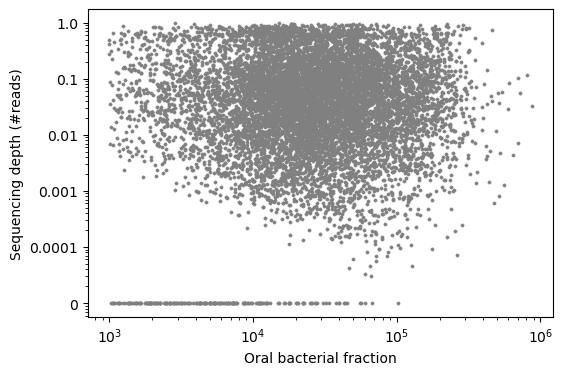

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

df2plot = pd.merge(df_sample, df_count.sum(axis=1).to_frame().rename({0:'Nreads'},axis=1), left_index=True, right_index=True, how='inner')
df2plot.loc[df2plot.OralFraction==0,'OralFraction'] = 1e-5

_ = sns.scatterplot(data=df2plot, x='Nreads', y='OralFraction', ax=ax, color='gray', edgecolor=None, s=6)
_ = ax.set_ylabel('Sequencing depth (#reads)')
_ = ax.set_xlabel('Oral bacterial fraction')
_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
_ = ax.set_yticks([1e-5,1e-4,1e-3,1e-2,1e-1,1e0])
_ = ax.set_yticklabels([0,1e-4,1e-3,1e-2,1e-1,1e0])

In [25]:
df2plot = pd.merge(df_sample, df_count.sum(axis=1).to_frame().rename({0:'Nreads'},axis=1), left_index=True, right_index=True, how='inner')
spearmanr(df2plot.OralFraction, df2plot.Nreads)

SignificanceResult(statistic=0.0030049123125591203, pvalue=0.7589256968158722)

# Fig. S3

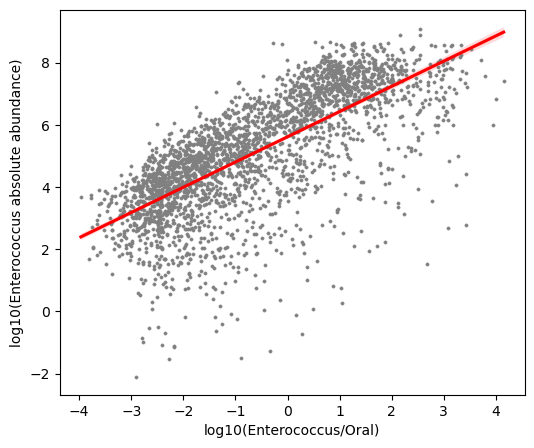

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))

df2plot = deepcopy(df_sample)
df2plot = df2plot[(df2plot.EnterococcusLoad>0) & (df2plot.OralFraction>0)]

_ = sns.regplot(data=df2plot, x='log10_Enterococcus2OralRatio', y='log10_EnterococcusLoad', ax=ax, scatter_kws={"color": "black"}, line_kws={"color": "red"}, scatter=False)
_ = sns.scatterplot(data=df2plot, x='log10_Enterococcus2OralRatio', y='log10_EnterococcusLoad', ax=ax, color='gray', edgecolor=None, s=6)
_ = ax.set_xlabel('log10(Enterococcus/Oral)')
_ = ax.set_ylabel('log10(Enterococcus absolute abundance)')

In [27]:
df2plot = deepcopy(df_sample)
df2plot = df2plot[(df2plot.EnterococcusLoad>0) & (df2plot.OralFraction>0)]
pearsonr(df2plot.log10_Enterococcus2OralRatio, df2plot.log10_EnterococcusLoad)

PearsonRResult(statistic=0.7081724676964427, pvalue=0.0)

In [28]:
len(df2plot)

2765

# Extended Data Fig. 6

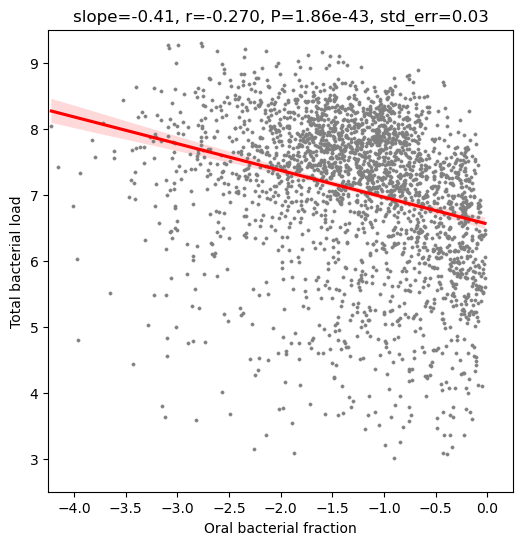

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

df2plot = df_sample[(df_sample.TotalLoad >= 1e3) & (df_sample.OralFraction > 0) & (df_sample.DayRelativeToNearestHCT >= -20) & (df_sample.DayRelativeToNearestHCT <= 40)]
_ = sns.regplot(data=df2plot, x='log10_OralFraction', y='log10_TotalLoad', ax=ax, scatter_kws={"color": "black"}, line_kws={"color": "red"}, scatter=False)
_ = sns.scatterplot(data=df2plot, x='log10_OralFraction', y='log10_TotalLoad', ax=ax, color='gray', edgecolor=None, s=6)
_ = ax.set_ylabel('Total bacterial load')
_ = ax.set_xlabel('Oral bacterial fraction')
slope, intercept, r_value, p_value, std_err = linregress(df2plot.log10_OralFraction, df2plot.log10_TotalLoad)
_ = ax.set_title('slope=%2.2f, r=%2.3f, P=%2.2e, std_err=%2.2f'%(slope, r_value, p_value, std_err))
_ = ax.set_xlim([-4.25, 0.25])
_ = ax.set_ylim([2.5,9.5])

In [30]:
len(df2plot)

2524

# Extended Data Fig. 9a

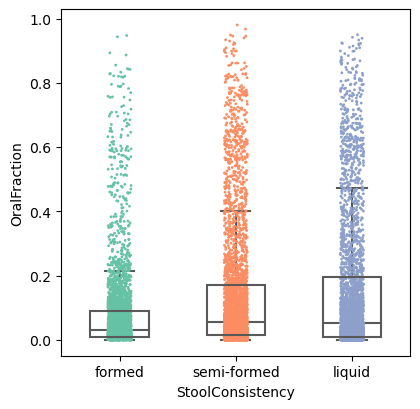

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5,4.5))

df2plot = df_sample[df_sample.StoolConsistency.notnull()]
_ = sns.stripplot(x='StoolConsistency', y='OralFraction', data=df2plot, ax=ax, order=['formed','semi-formed','liquid'], palette='Set2', jitter=0.1, s=2)
_ = sns.boxplot(x="StoolConsistency", y="OralFraction", data=df2plot, saturation=1, showfliers=False, width=0.5, palette='Set2', boxprops={'zorder': 30, 'facecolor': 'none'}, ax=ax, order=['formed','semi-formed','liquid'])

In [32]:
Counter(df2plot.StoolConsistency)

Counter({'semi-formed': 3692, 'formed': 3490, 'liquid': 3201})

In [33]:
res = mannwhitneyu(df2plot[df2plot.StoolConsistency=='formed'].OralFraction, df2plot[df2plot.StoolConsistency=='semi-formed'].OralFraction)
print("formed vs semi-formed", res)
res = mannwhitneyu(df2plot[df2plot.StoolConsistency=='semi-formed'].OralFraction, df2plot[df2plot.StoolConsistency=='liquid'].OralFraction)
print("semi-formed vs liquid", res)
res = mannwhitneyu(df2plot[df2plot.StoolConsistency=='formed'].OralFraction, df2plot[df2plot.StoolConsistency=='liquid'].OralFraction)
print("formed vs liquid", res)

formed vs semi-formed MannwhitneyuResult(statistic=5354218.5, pvalue=2.876703300994296e-35)
semi-formed vs liquid MannwhitneyuResult(statistic=6034730.0, pvalue=0.1271787925356687)
formed vs liquid MannwhitneyuResult(statistic=4861268.0, pvalue=4.361798134599105e-20)


In [34]:
multipletests([2.9e-35, 0.127, 4.4e-20], method='fdr_bh')

(array([ True, False,  True]),
 array([8.70e-35, 1.27e-01, 6.60e-20]),
 0.016952427508441503,
 0.016666666666666666)

In [35]:
for pair in [('formed','semi-formed'),('semi-formed','liquid'),('formed','liquid')]:
    df2 = df2plot.loc[(df2plot.StoolConsistency==pair[0])|(df2plot.StoolConsistency==pair[1]), ['StoolConsistency','OralFraction']]
    
    # Variances
    variances = df2.groupby('StoolConsistency').var(ddof=1)
    # Mean variance
    mean_var = variances.mean().values[0]
    # Pooled standard deviation
    s_pooled = np.sqrt(mean_var)
    # Difference of the means
    diff_mean = abs(df2.groupby('StoolConsistency').mean().diff().values[-1])
    # Cohen's d
    cohens_d = diff_mean / s_pooled
    
    print(pair, "Cohen's d = %.3f"%(cohens_d))

('formed', 'semi-formed') Cohen's d = 0.352
('semi-formed', 'liquid') Cohen's d = 0.059
('formed', 'liquid') Cohen's d = 0.400


# Extended Data Fig. 9b

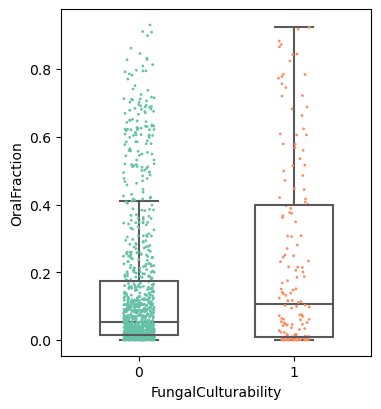

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4.5))

df2plot = df_sample[df_sample.FungalCulturability.notnull()]
df2plot.FungalCulturability = df2plot.FungalCulturability.astype(int).astype(str)
_ = sns.stripplot(x='FungalCulturability', y='OralFraction', data=df2plot, ax=ax, order=['0','1'], palette='Set2', jitter=0.1, s=2)
_ = sns.boxplot(x="FungalCulturability", y="OralFraction", data=df2plot, saturation=1, showfliers=False, width=0.5, palette='Set2', boxprops={'zorder': 30, 'facecolor': 'none'}, ax=ax, order=['0','1'])

In [37]:
Counter(df2plot.FungalCulturability)

Counter({'0': 978, '1': 156})

In [38]:
mannwhitneyu(df2plot[df2plot.FungalCulturability=='0'].OralFraction, df2plot[df2plot.FungalCulturability=='1'].OralFraction)

MannwhitneyuResult(statistic=67260.0, pvalue=0.017530010145055543)

In [39]:
df2 = df2plot[['FungalCulturability','OralFraction']]

# Variances
variances = df2.groupby('FungalCulturability').var(ddof=1)
# Mean variance
mean_var = variances.mean().values[0]
# Pooled standard deviation
s_pooled = np.sqrt(mean_var)
# Difference of the means
diff_mean = abs(df2.groupby('FungalCulturability').mean().diff().values[-1])
# Cohen's d
cohens_d = diff_mean / s_pooled

print("Cohen's d = %.3f"%(cohens_d))

Cohen's d = 0.345
